In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from PyHEADTAIL_feedback.processors import Lowpass, PhaseLinearizedLowpass, Sinc, NoiseGenerator

np.random.seed(0)

In [2]:
class Signal(object):
    def __init__(self, z_bins,z,x,t):
        self.z_bins = z_bins
        self.z = z
        self.x = x
        self.t = t
        self.signal = np.array(x)
        
    def mean_x(self):
        return self.x
        
    def mean_z(self):
        return self.z

def impulse(f, n_points = 100, amplitude = 1.):
    t_bins = np.linspace(-1./f, 1./f, n_points + 1)

    t = np.array([(i + j) / 2. for i, j in zip(t_bins, t_bins[1:])])

    z_bins = c * t_bins
    z = c * t

    x = np.zeros(len(t))
    for i, val in enumerate(t):
        if val >= 0.:
            x[i] = amplitude
            break
    print np.amax(x)
            
    return Signal(z_bins, z, x, t)
    
def generate_signal(signal_generator, f, amplitude, n_periods, n_per_period, n_zero_periods):
    
    t_min = -1.*n_zero_periods[0]
    t_max = n_periods+n_zero_periods[1]
    t_bins = np.linspace(t_min,t_max,int((t_max-t_min)*n_per_period)+1)
    t = np.array([(i + j) / 2. for i, j in zip(t_bins, t_bins[1:])])

    x = np.zeros(len(t))
    signal_points = (t > 0.) * (t < n_periods)
    x[signal_points] = amplitude * signal_generator(t[signal_points])

    z_bins = c * t_bins / f
    z = c * t / f

    return Signal(z_bins, z, x, t / f )
    
    
def square_signal(f,amplitude):
    def signal_generator(x):
        signal = np.zeros(len(x))
        for i, val in enumerate(x):

            if 0.< val % 1. < 0.5:
                signal[i] = 1.

            elif 0.5 < val % 1. < 1.0:
#                 if type == 'unipolar':
#                     signal[i] = 1.

#                 elif type == 'bipolar':
                signal[i] = -1.

#                 else:
#                     signal[i] = 0.
        return signal

    return generate_signal(signal_generator, f, amplitude, 1, 100, (1,1))
    

def sine_signal(f,amplitude):
    def signal_generator(x):
        return np.sin(2*pi*x)

    return generate_signal(signal_generator, f, amplitude, 1, 100, (1,1))

def compare_signals(signals,labels,normalized = False):
    fig = plt.figure(figsize=(12, 7))
    ax1 = fig.add_subplot(111)
    
    ax2 = ax1.twiny()
    
    norm_coeff = 1.
    
    for i, (signal,label) in enumerate(zip(signals,labels)):
        if normalized and i == 0:
            norm_coeff = np.amax(signal.signal)

        ax1.plot(signal.t, signal.signal/norm_coeff,label=label)
        ax2.plot(signal.z, np.ones(len(signal.z))) # Create a dummy plot
        ax2.cla()

    
    ax1.set_xlabel('Time [s]')
    if normalized:
        ax1.set_ylabel('Normalized amplitude')
    else:
        ax1.set_ylabel('Amplitude')
        
    ax1.legend(loc='upper right')
    
    ax2.set_xlabel('Distance [m]')
    plt.show()
    
def process_signal(signal,processors):
    
    for processor in processors:
        signal.signal = processor.process(signal.signal,signal,None)

In [3]:
""" In this example signal processing of different ("analog") signal processors are demonstrated. In order to
    clarify the presentation signals are produced independently of the PyHEADTAIL
"""

u' In this example signal processing of different ("analog") signal processors are demonstrated. In order to\n    clarify the presentation signals are produced independently of the PyHEADTAIL\n'

1.0
1.0
1.0


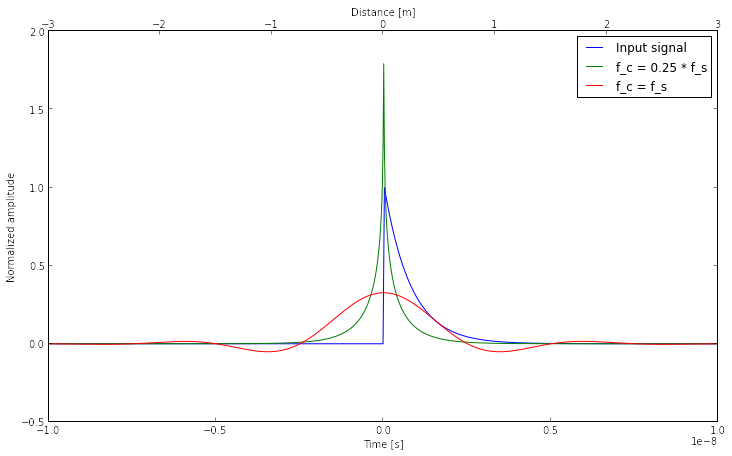

In [4]:
# The simplest way to limit bandwidth of the feedback system is to use low pass filters. At the moment there 
# are three different lowpass filter implemented. 

f_s = 1e8

signal_1 = impulse(f_s,1000)
processors_1 = [Lowpass(2*f_s)]
process_signal(signal_1,processors_1)

signal_2 = impulse(f_s,1000)
processors_2 = [PhaseLinearizedLowpass(2*f_s)]
process_signal(signal_2,processors_2)

signal_3 = impulse(f_s,1000)
processors_3 = [Sinc(2*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s'],True)

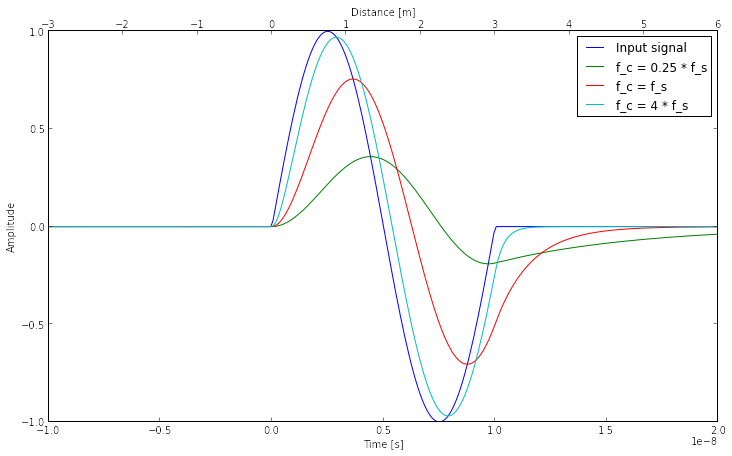

In [5]:
# The simplest filter (Lowpass(...)) is called by RC-filter or one pole roll off. In real life it can be
# implemented by using a resistor and a capacitor. Charasteristic properties of this filter are that
# trh

signal_org = sine_signal(f_s,1.0)

signal_1 = sine_signal(f_s,1.0)
processors_1 = [Lowpass(0.25*f_s)]
process_signal(signal_1,processors_1)

signal_2 = sine_signal(f_s,1.0)
processors_2 = [Lowpass(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_signal(f_s,1.0)
processors_3 = [Lowpass(4.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])

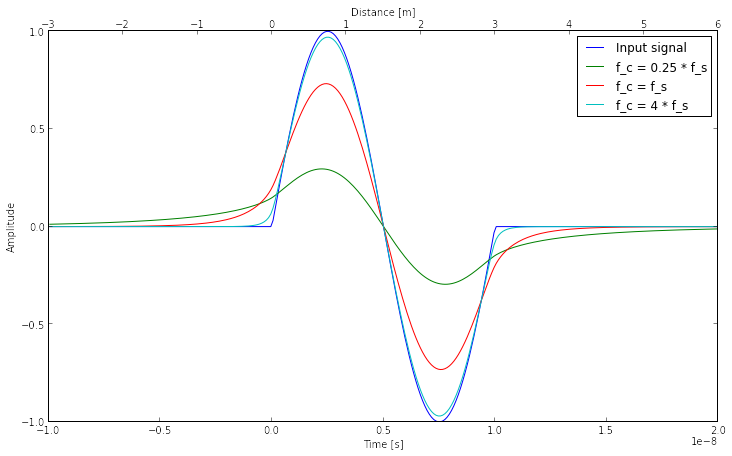

In [6]:
signal_org = sine_signal(f_s,1.0)

signal_1 = sine_signal(f_s,1.0)
processors_1 = [PhaseLinearizedLowpass(0.25*f_s)]
process_signal(signal_1,processors_1)

signal_2 = sine_signal(f_s,1.0)
processors_2 = [PhaseLinearizedLowpass(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_signal(f_s,1.0)
processors_3 = [PhaseLinearizedLowpass(4.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])

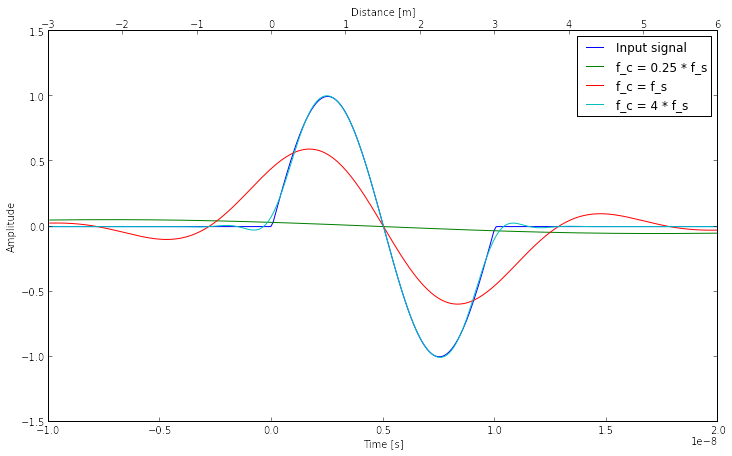

In [7]:
signal_org = sine_signal(f_s,1.0)

signal_1 = sine_signal(f_s,1.0)
processors_1 = [Sinc(0.25*f_s)]
process_signal(signal_1,processors_1)

signal_2 = sine_signal(f_s,1.0)
processors_2 = [Sinc(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_signal(f_s,1.0)
processors_3 = [Sinc(4.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])

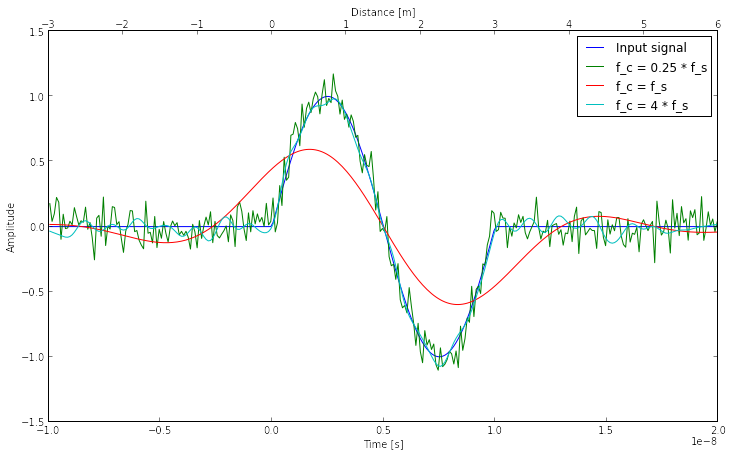

In [8]:
signal_org = sine_signal(f_s,1.0)

signal_1 = sine_signal(f_s,1.0)
processors_1 = [NoiseGenerator(0.1)]
process_signal(signal_1,processors_1)

signal_2 = sine_signal(f_s,1.0)
processors_2 = [NoiseGenerator(0.1),Sinc(1.0 *f_s)]
process_signal(signal_2,processors_2)

signal_3 = sine_signal(f_s,1.0)
processors_3 = [NoiseGenerator(0.1),Sinc(10.*f_s)]
process_signal(signal_3,processors_3)


compare_signals([signal_org, signal_1, signal_2, signal_3],
                ['Input signal', 'f_c = 0.25 * f_s',  'f_c = f_s',  'f_c = 4 * f_s'])